In [1]:
!pip install torchinfo

In [2]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torchinfo import summary
from tqdm import tqdm

import matplotlib.pyplot as plt

import pandas as pd

In [3]:
batch_size, hidden_size = 128, 64
seq_len = 28
input_size = 28
num_classes = 10

# Torch Imports

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ]
    )
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ]
    )
)

100%|██████████| 26421880/26421880 [00:00<00:00, 118416134.15it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5096746.78it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 66719329.87it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21463496.02it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

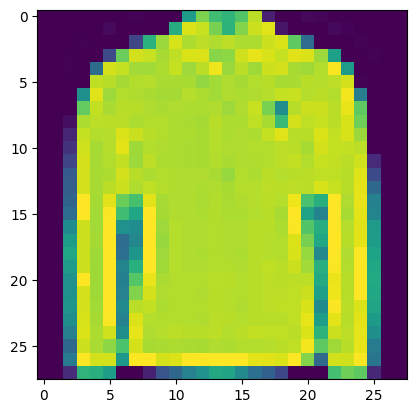

In [7]:
for (x, y) in train_dataloader:
    plt.imshow(x[0].squeeze())
    break

# RNN

## CustomRNN: LinearEx (Dense), RNNCellEx (memory_cell), RNNLayer (simpleRNN)

In [8]:
sample = next(iter(train_dataloader))[0].squeeze()

In [9]:
class LinearEx(nn.Module):
    __constants__ = ['in_features', 'out_features', 'bias']

    def __init__(self, in_features: int, out_features: int, bias: bool = True, device: str = 'cpu', **kwargs):
        super(LinearEx, self).__init__(**kwargs)

        self.use_bias = bias

        self.weights = nn.Parameter(data=torch.randn(size=(out_features, in_features), device=device), requires_grad=True)
        if self.use_bias: self.bias = nn.Parameter(data=torch.randn(size=(out_features, 1), device=device), requires_grad=True)

    def forward(self, inputs: torch.Tensor):
        inputs = inputs.to(device)

        if self.use_bias:
            return torch.matmul(inputs, torch.transpose(self.weights, dim0=0, dim1=1)) + self.bias.squeeze()
        else: return torch.matmul(inputs, torch.transpose(self.weights, dim0=0, dim1=1))

In [11]:
sample.shape

torch.Size([128, 28, 28])

torch.Size([128, 64])


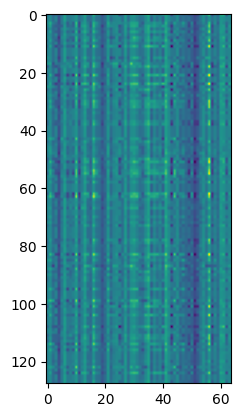

In [10]:
linear_layer = LinearEx(in_features=sample.size(-1), out_features=hidden_size).to(device)
layer_pred = list(linear_layer(sample[:, sequence, :]) for sequence in range(sample.size(1)))
print(layer_pred[0].size())
plt.imshow(layer_pred[0].detach().cpu())

In [12]:
class SimpleAttention1d(nn.Module):
    __constants__ = ['input_size']

    def __init__(self, input_size: int, device: str = 'cpu'):
        super(SimpleAttention1d, self).__init__()

        self.linear = LinearEx(in_features=input_size, out_features=input_size, device=device)
        self.batch_norm = nn.BatchNorm1d(num_features=input_size, device=device)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs: torch.Tensor):
        inputs = inputs.to(device)

        logits = self.softmax(self.batch_norm(self.linear(inputs)))
        embeddings = torch.multiply(inputs, logits)

        return embeddings

In [13]:
def plot_results(image_1, image_2):
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 2, 1)
    plt.xticks([]), plt.yticks([])
    ax.imshow(image_1)

    ax = fig.add_subplot(1, 2, 2)
    plt.xticks([]), plt.yticks([])
    ax.imshow(image_2)

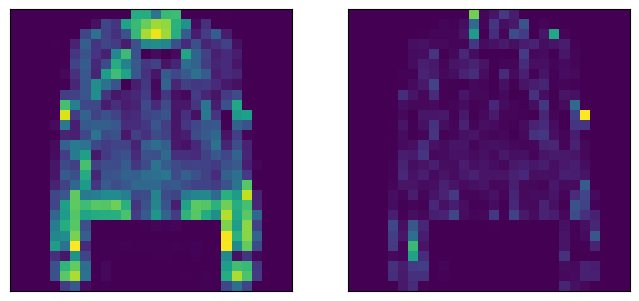

In [14]:
att_layer = SimpleAttention1d(input_size=sample.size(-1)).to(device)
a_att = att_layer(sample[0]).detach().cpu()

plot_results(sample[0], a_att)

In [15]:
class RNNCellEx(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'bias', 'nonlinearity']

    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh', device: str = 'cpu'):
        super(RNNCellEx, self).__init__()

        self.nonlinearity = nonlinearity

        self.in_to_hidden = LinearEx(in_features=input_size, out_features=hidden_size, bias=bias, device=device)
        #self.in_to_hidden = LinearEx(in_features=input_size + hidden_size, out_features=hidden_size, bias=bias, device=device)
        self.hidden_to_hidden = LinearEx(in_features=hidden_size, out_features=hidden_size, bias=bias, device=device)

        self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size).to(device)

    def forward(self, inputs: torch.Tensor, states: torch.Tensor) -> torch.Tensor:
        if self.nonlinearity == 'tanh':
            tanh = nn.Tanh()
            states = tanh(self.layer_norm(self.in_to_hidden(inputs) + self.hidden_to_hidden(states)))
            return states

        elif self.nonlinearity == 'relu':
            relu = nn.ReLU()
            states = relu(self.layer_norm(self.in_to_hidden(inputs) + self.hidden_to_hidden(states)))
            return states

        else:
            raise RuntimeError('Unknown nonlinearity: %s' % self.nonlinearity)

CPU times: user 65.3 ms, sys: 905 µs, total: 66.2 ms
Wall time: 72 ms


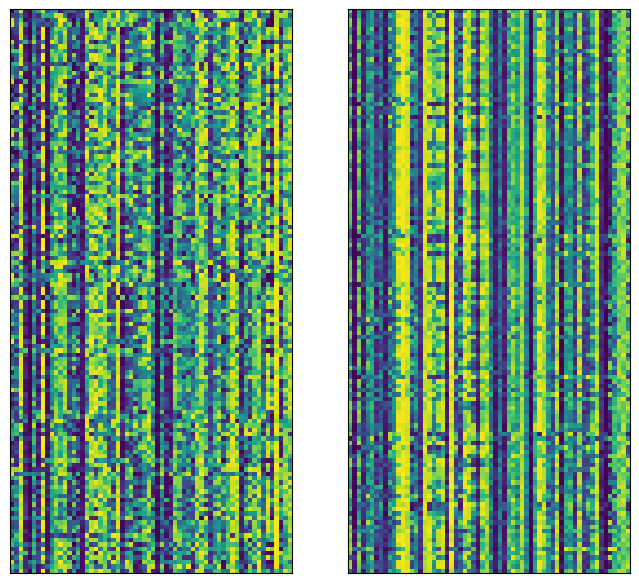

In [16]:
%%time
input = sample # (batch_size, seq_len, input_size)
h0_1 = torch.zeros(input.size(0), hidden_size) # batch_first=True
h0_2 = torch.zeros(input.size(0), hidden_size)

rnn_cell_layer = RNNCellEx(input_size=input.size(-1), hidden_size=hidden_size).to(device)
att_layer = SimpleAttention1d(input_size=input.size(-1)).to(device)

for sequence in range(input.size(1)):
    x = att_layer(input[:, sequence, :])
    h0_1 = rnn_cell_layer(x, h0_1)
pred_att_rnn = h0_1

for sequence in range(input.size(1)):
    h0_2 = rnn_cell_layer(input[:, sequence, :], h0_2)
pred_rnn = h0_2

plot_results(pred_rnn.detach().cpu(), pred_att_rnn.detach().cpu())

In [17]:
class RNNLayer(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'output_size', 'batch_first', 'num_layers', 'bias', 'nonlinearity', 'attention']

    def __init__(self, input_size: int, hidden_size: int, output_size: int, batch_first: bool = False, num_layers: int = 1,
                 bias: bool = True, nonlinearity: str = 'tanh', attention: bool = False, device: str = 'cpu'):
        super(RNNLayer, self).__init__()
        cond_factory = {'nonlinearity': nonlinearity, 'bias': bias}

        self.num_layers = num_layers
        self.batch_first = batch_first

        self.hidden_size = hidden_size
        self.out = output_size

        self.attention = attention
        if self.attention: self.att_layer = SimpleAttention1d(input_size=input_size).to(device)

        self.rnn_cells = nn.ModuleList()
        self.rnn_cells.append(RNNCellEx(input_size=input_size, hidden_size=hidden_size, **cond_factory).to(device)) # input cell
        for _ in range(self.num_layers - 1):
            self.rnn_cells.append(RNNCellEx(input_size=hidden_size, hidden_size=hidden_size, **cond_factory).to(device)) # hidden cells

        if self.out is not None: self.hidden_to_output = LinearEx(in_features=hidden_size, out_features=output_size, bias=bias).to(device)


    def forward(self, inputs: torch.Tensor):
        max_batch_size = inputs.size(0) if self.batch_first else inputs.size(1)
        sequence_len = inputs.size(1) if self.batch_first else inputs.size(0)

        states = torch.autograd.Variable(torch.zeros(size=(self.num_layers, max_batch_size, self.hidden_size))).to(device)
        memory_cell = list(states[layer] for layer in range(self.num_layers))

        for sequence in range(sequence_len):
            if self.attention: x = self.att_layer(inputs[:, sequence, :]) if self.batch_first else self.att_layer(inputs[sequence, :, :])
            else: x = inputs[:, sequence, :] if self.batch_first else inputs[sequence, : , :]

            for layer in range(self.num_layers):
                if layer == 0: state = self.rnn_cells[layer](x, memory_cell[layer])
                else: state = self.rnn_cells[layer](memory_cell[layer - 1], memory_cell[layer])
                memory_cell[layer] = state

        if self.out is not None: state = self.hidden_to_output(state)
        return state, memory_cell

## Training & Scoring

In [48]:
import time

def train_model(data, model, loss_fn, optimizer, scheduler = None, scheduler_step: int = 100, epochs: int = 3, show_step: int = 100):
    count = 0
    n_total_steps = len(data)

    for epoch in range(epochs):
        epoch_start_time = time.time()
        print('Epoch %s/%s' % (epoch + 1, epochs))

        for step, (images, labels) in enumerate(data):
            optimizer.zero_grad()

            train  = images.squeeze().to(device)
            labels = labels.to(device)

            output, _ = model(train)

            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            count += 1

            if (step+1) % show_step == 0:
                print (f'Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  Loss: {loss.item():.4f}')
            if (scheduler is not None) and (step % scheduler_step == 0): scheduler.step()
        print('-' * 45)

In [47]:
def scoring(data, model):
    with torch.no_grad():
        scores = []
        true_labels = []
        for (images, labels) in tqdm(data, desc='Scoring data...', ncols=80):
            images = images.squeeze().to(device)
            labels = labels.to(device)

            output, _ = model(images)

            scores.append(output)
            true_labels.append(labels)

        scores = torch.concatenate(scores)
        true_labels = torch.concatenate(true_labels)

        return pd.DataFrame(scores.cpu(), columns=list(range(10))), true_labels

In [107]:
def accuracy(scores, y_true):
    pred = []
    print('Compute accuracy... ')
    for score in scores.values:
        for key, value in dict(enumerate(score)).items():
            if score.max() == value: pred.append(key)

    n_correct = 0
    for index, value in enumerate(pred):
        if value == y_true[index].cpu().numpy(): n_correct += 1

    return n_correct / len(y_true)

In [153]:
model_custom = RNNLayer(input_size=input_size, hidden_size=hidden_size, output_size=num_classes,
                        batch_first=True, num_layers=2, nonlinearity='tanh', attention=True).to(device)
model_custom

RNNLayer(
  (att_layer): SimpleAttention1d(
    (linear): LinearEx()
    (batch_norm): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (softmax): Softmax(dim=1)
  )
  (rnn_cells): ModuleList(
    (0-1): 2 x RNNCellEx(
      (in_to_hidden): LinearEx()
      (hidden_to_hidden): LinearEx()
      (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (hidden_to_output): LinearEx()
)

In [154]:
summary(model_custom, input_size=input.size())

Layer (type:depth-idx)                   Output Shape              Param #
RNNLayer                                 [128, 10]                 --
├─SimpleAttention1d: 1-1                 [128, 28]                 --
│    └─LinearEx: 2-1                     [128, 28]                 812
│    └─BatchNorm1d: 2-2                  [128, 28]                 56
│    └─Softmax: 2-3                      [128, 28]                 --
├─ModuleList: 1-56                       --                        (recursive)
│    └─RNNCellEx: 2-4                    [128, 64]                 --
│    │    └─LinearEx: 3-1                [128, 64]                 1,856
│    │    └─LinearEx: 3-2                [128, 64]                 4,160
│    │    └─LayerNorm: 3-3               [128, 64]                 128
│    └─RNNCellEx: 2-5                    [128, 64]                 --
│    │    └─LinearEx: 3-4                [128, 64]                 4,160
│    │    └─LinearEx: 3-5                [128, 64]               

In [155]:
opt = torch.optim.Adam(model_custom.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)

In [156]:
train_model(
    data=train_dataloader,
    model=model_custom,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=opt,
    scheduler=scheduler,
    scheduler_step=len(train_dataloader),
    epochs=5,
    show_step=50
)

Epoch 1/5
Step [50/469] | Time: 2.79s |  Loss: 2.2818
Step [100/469] | Time: 5.89s |  Loss: 2.0963
Step [150/469] | Time: 8.51s |  Loss: 1.3238
Step [200/469] | Time: 11.17s |  Loss: 1.3018
Step [250/469] | Time: 13.85s |  Loss: 0.9861
Step [300/469] | Time: 17.01s |  Loss: 0.9199
Step [350/469] | Time: 19.62s |  Loss: 0.9101
Step [400/469] | Time: 22.20s |  Loss: 0.8839
Step [450/469] | Time: 24.74s |  Loss: 0.9123
---------------------------------------------
Epoch 2/5
Step [50/469] | Time: 3.11s |  Loss: 0.6950
Step [100/469] | Time: 5.75s |  Loss: 0.8777
Step [150/469] | Time: 8.33s |  Loss: 0.5696
Step [200/469] | Time: 10.90s |  Loss: 0.7777
Step [250/469] | Time: 13.89s |  Loss: 0.7479
Step [300/469] | Time: 16.48s |  Loss: 0.7238
Step [350/469] | Time: 19.11s |  Loss: 0.5385
Step [400/469] | Time: 21.73s |  Loss: 0.6306
Step [450/469] | Time: 24.66s |  Loss: 0.5891
---------------------------------------------
Epoch 3/5
Step [50/469] | Time: 2.58s |  Loss: 0.5786
Step [100/469]

In [157]:
train_scores, true_labels = scoring(train_dataloader, model_custom)
train_scores

Scoring data...: 100%|████████████████████████| 469/469 [00:15<00:00, 29.88it/s]


,0,1,2,3,4,5,6,7,8,9
0,5.803318,-1.567142,3.070968,4.336853,2.030762,-3.475795,4.801703,-6.079379,-0.508204,-6.972584
1,0.364579,0.720487,1.270428,3.036809,5.828571,-2.662060,2.647776,-8.385864,0.053953,-7.429590
2,-1.406604,1.066560,2.910615,-0.844043,4.776592,1.976580,4.485478,-4.478778,0.753728,0.247825
3,2.934760,6.338729,0.325168,7.543864,1.809910,1.948860,1.334736,-0.060774,0.559888,-0.193901
4,3.371219,2.946008,1.329310,6.260067,4.177752,-3.186045,3.202302,-5.144248,-0.437677,-5.481575
...,...,...,...,...,...,...,...,...,...,...
59995,0.465290,0.032582,7.850749,1.768174,7.662924,-1.242878,4.570780,-6.689454,-0.327109,-1.097282
59996,2.936366,0.653421,7.432131,3.533779,3.911480,-1.771870,5.267940,-3.774720,-1.417225,-3.443783
59997,2.051602,0.608047,4.673854,2.353831,4.021979,-3.040610,4.476631,-5.247840,0.902285,-3.647785
59998,-0.128058,2.521989,-2.182268,-6.947182,-0.827635,9.401294,-4.146354,12.359016,4.964705,6.302346


In [158]:
test_scores, true_labels_test = scoring(test_dataloader, model_custom)
test_scores

Scoring data...: 100%|██████████████████████████| 79/79 [00:02<00:00, 31.12it/s]


,0,1,2,3,4,5,6,7,8,9
0,-1.594772,3.887347,-2.140662,-2.211907,2.498708,8.184733,-6.730761,11.532011,5.285590,12.237614
1,3.846262,1.568949,9.511999,3.031597,5.907529,-2.025562,6.698056,-3.973757,-0.900068,-1.155058
2,1.745808,10.850077,1.119097,-0.027323,-0.008153,-5.072433,4.064703,-3.254372,1.758897,-4.986663
3,2.233666,11.892824,0.149450,2.282109,-0.976678,-2.724659,0.966577,0.840499,1.083354,-1.054766
4,3.827088,1.595096,2.789279,1.156692,0.719998,-3.325521,4.293729,-2.894303,-1.420517,-7.519163
...,...,...,...,...,...,...,...,...,...,...
9995,-2.694948,3.549805,-1.863970,-1.171210,3.454316,8.030925,-6.967648,9.257099,5.156468,13.476953
9996,3.436088,8.222753,0.873923,5.320795,1.882956,-3.881943,2.645056,-3.156965,1.414082,-4.616650
9997,3.811536,0.474776,2.023993,3.957579,0.650232,0.151344,2.095915,-3.043855,6.013007,-5.172879
9998,1.668050,10.629993,0.415352,4.171874,2.211342,-5.550063,2.518819,-2.405835,1.333990,-4.337975


In [159]:
print('Accuracy on train: %.4f \n' % accuracy(train_scores, true_labels))
print('Accuracy on test: %.4f' % accuracy(test_scores, true_labels_test))

Compute accuracy... 
Accuracy on train: 0.8100 

Compute accuracy... 
Accuracy on test: 0.8040


## Torch RNN

In [129]:
class RNNTorch(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'output_size', 'num_layers', 'bias', 'batch_first', 'nonlinearity']

    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1, batch_first: bool = False,
                 bias: bool = True, nonlinearity: str = 'tanh', attention: bool = False, device: str = 'cpu'):
        super(RNNTorch, self).__init__()

        cond_factory = {'nonlinearity': nonlinearity, 'bias': bias}
        self.batch_first = batch_first

        self.att = attention
        if self.att: self.att_layer = SimpleAttention1d(input_size=input_size).to(device)

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, **cond_factory).to(device)

        self.hidden_to_output = nn.Linear(in_features=hidden_size, out_features=output_size, bias=bias).to(device)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        inputs = inputs.to(device)

        if self.att: inputs = self.att_layer(inputs)

        self.memory_cell, states = self.rnn(inputs)

        self.memory_cell = self.hidden_to_output(self.memory_cell[:, -1, :] if self.batch_first else self.memory_cell[-1, :, :])
        return self.memory_cell, states

In [140]:
model_rnn_torch = RNNTorch(input_size=input_size, hidden_size=hidden_size, output_size=num_classes,
                           batch_first=True, num_layers=2, nonlinearity='relu', attention=False).to(device)
model_rnn_torch

RNNTorch(
  (rnn): RNN(28, 64, num_layers=2, batch_first=True)
  (hidden_to_output): Linear(in_features=64, out_features=10, bias=True)
)

In [141]:
summary(model_rnn_torch, input_size=input.shape)

Layer (type:depth-idx)                   Output Shape              Param #
RNNTorch                                 [128, 10]                 --
├─RNN: 1-1                               [128, 28, 64]             14,336
├─Linear: 1-2                            [128, 10]                 650
Total params: 14,986
Trainable params: 14,986
Non-trainable params: 0
Total mult-adds (M): 51.46
Input size (MB): 0.40
Forward/backward pass size (MB): 1.85
Params size (MB): 0.06
Estimated Total Size (MB): 2.31

In [142]:
opt = torch.optim.Adam(model_rnn_torch.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)

In [143]:
train_model(
    data=train_dataloader,
    model=model_rnn_torch,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=opt,
    scheduler=scheduler,
    scheduler_step=len(train_dataloader),
    epochs=5,
    show_step=50
)

Epoch 1/5
Step [50/469] | Time: 0.96s |  Loss: 1.2703
Step [100/469] | Time: 1.93s |  Loss: 1.0635
Step [150/469] | Time: 2.84s |  Loss: 1.1956
Step [200/469] | Time: 3.75s |  Loss: 0.8917
Step [250/469] | Time: 4.62s |  Loss: 0.8622
Step [300/469] | Time: 5.53s |  Loss: 0.8047
Step [350/469] | Time: 6.48s |  Loss: 0.7693
Step [400/469] | Time: 7.43s |  Loss: 0.7961
Step [450/469] | Time: 8.32s |  Loss: 0.8741
---------------------------------------------
Epoch 2/5
Step [50/469] | Time: 1.14s |  Loss: 0.5570
Step [100/469] | Time: 2.32s |  Loss: 0.4805
Step [150/469] | Time: 3.24s |  Loss: 0.5035
Step [200/469] | Time: 4.17s |  Loss: 0.6528
Step [250/469] | Time: 5.09s |  Loss: 0.5765
Step [300/469] | Time: 6.01s |  Loss: 0.5498
Step [350/469] | Time: 6.95s |  Loss: 0.5891
Step [400/469] | Time: 7.90s |  Loss: 0.4326
Step [450/469] | Time: 8.82s |  Loss: 0.3898
---------------------------------------------
Epoch 3/5
Step [50/469] | Time: 0.92s |  Loss: 0.4649
Step [100/469] | Time: 1.8

In [144]:
train_scores, true_labels = scoring(train_dataloader, model_rnn_torch)
test_scores, true_labels_test = scoring(test_dataloader, model_rnn_torch)

Scoring data...: 100%|██████████████████████████| 79/79 [00:01<00:00, 59.21it/s]


In [145]:
print('Accuracy on train: %.4f \n' % accuracy(train_scores, true_labels))
print('Accuracy on test: %.4f' % accuracy(test_scores, true_labels_test))

Compute accuracy... 
Accuracy on train: 0.8617 

Compute accuracy... 
Accuracy on test: 0.8517
